## **Used model to segment new data**
### **Author:** Alessandro Ulivi (ale.ulivi@gmail.com)
### **Start day (yyyy/mm/dd):** 2024/11/24
### **Description**
#### The notebook loads a trained model, uses it to segment new data and saves the results.

### **Requirements**
#### The notebook runs on the pip2_segmentation environment and using the scripts of the pip2_segmentation project. Refer to https://github.com/AlessandroUlivi/pip2_segmentation.

## **THE NOTEBOOK IS VERY EARLY IN THE DEVELOPMENT PHASE. MANY MANY STEPS HAVE TO BE IMPLEMENTED, STARTING FROM THE FACT THAT DATA SHOULD BE ENTIRE IMAGES WHICH SHOULD BE NORMALIZED AND CHUNK BEFORE BEING PASSED TO THE MODEL, AND THEN RE-ASSEMBLED, BY ALSO FINDING A STRATEGY TO DEAL WITH THE IMAGE PADDING **

In [1]:
#Import required modules
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import torch
from utils.utils_funct import load_checkpoint, get_random_image_label_pair
from models.unet import UNet
from dataprep.data_preparation import add_channel_and_batch, load_dataset

In [2]:
#=========
# pass to device
# if torch.cuda.is_available:
#     print("using gpu")
#     device = torch.device("cuda")
# else:
#     print("using cpu")
#     device = torch.device("cpu")
device = torch.device("cpu")

#=========
# set model's parameters
final_activation="Sigmoid"
depth = 3
num_fmaps = 64
fmap_inc_factor = 4
downsample_factor = 2
kernel_size = 3
padding = "valid"
upsample_mode = "nearest"
unet_model = UNet(depth=depth,
                  in_channels=1,
                  out_channels=1,
                  final_activation=final_activation,
                  num_fmaps=num_fmaps,
                  fmap_inc_factor=fmap_inc_factor,
                  downsample_factor=downsample_factor,
                  kernel_size=kernel_size,
                  padding=padding,
                  upsample_mode=upsample_mode).to(device)


#load checkpoint of the model to test
checkpoint_save_path = "checkpoints"
checkpoint_key = "20241112-133730"
model = load_checkpoint(model=unet_model,
                        path=checkpoint_save_path,
                        optimizer=None,
                        key=checkpoint_key,
                        map_location=torch.device('cpu'))



c:\Users\aless\OneDrive\Desktop\Ale\personal\projects\pip2_segmentation\code\utils\utils_funct.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(lo

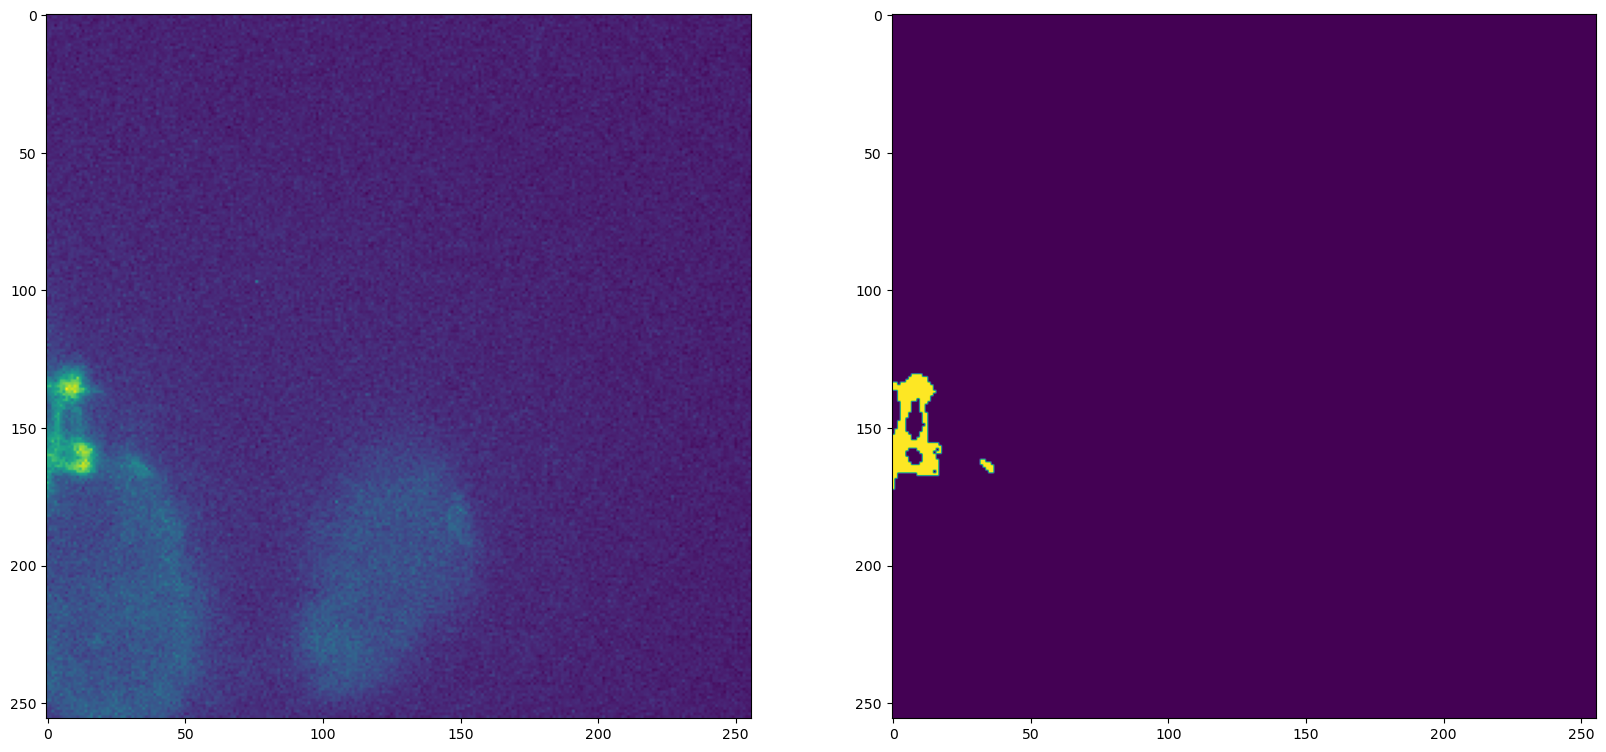

In [ ]:
# torch.from_numpy(image.copy())
val_input_data_dir = r""
val_label_data_dir = r""

val_data_set_images, val_data_set_labels = load_dataset(val_input_data_dir, val_label_data_dir)
val_data_item_np, val_label_item_np = get_random_image_label_pair(val_data_set_images, val_data_set_labels)

val_data_item_tensor = torch.from_numpy(add_channel_and_batch(val_data_item_np).copy())

fig1, ax1 = plt.subplots(1,2, figsize=(20,20))

ax1[0].imshow(val_data_item_tensor.detach().numpy()[0,0,...])
ax1[1].imshow(val_label_item_np)

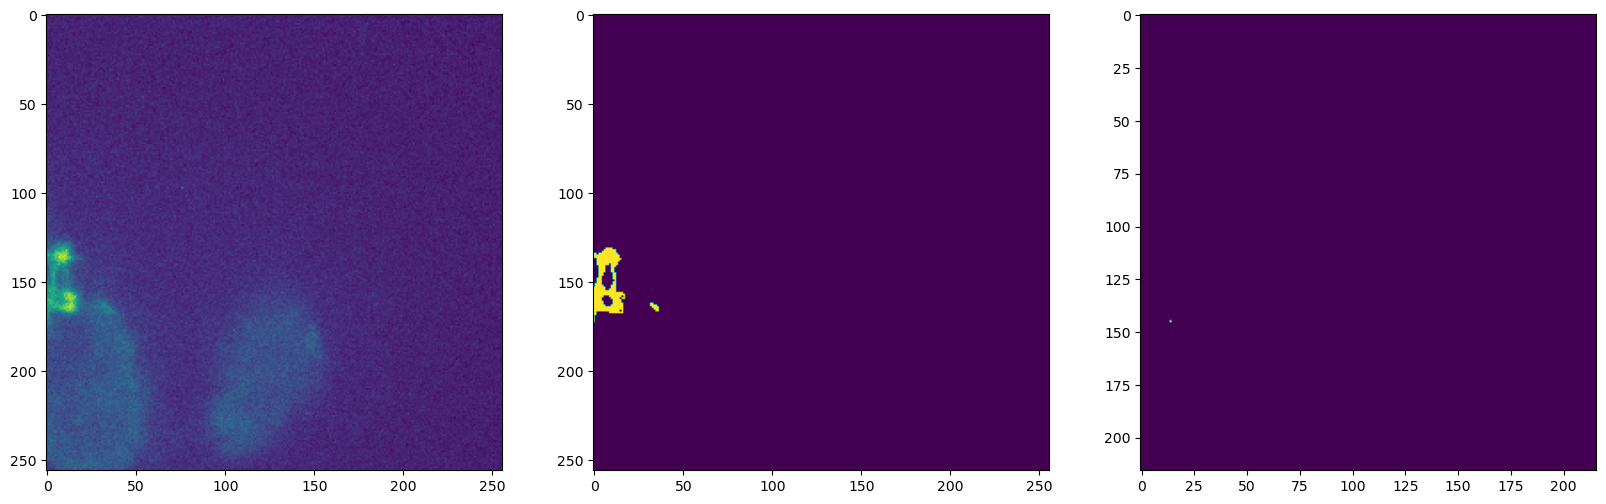

In [4]:
val_data_item_prediction = model(val_data_item_tensor)
bin_val_data_item_prediction = torch.where(val_data_item_prediction>0.5, 1,0)

fig2, ax2 = plt.subplots(1,3, figsize=(20,20))

ax2[0].imshow(val_data_item_tensor.detach().numpy()[0,0,...])
ax2[1].imshow(val_label_item_np)
ax2[2].imshow(bin_val_data_item_prediction.detach().numpy()[0,0,...])

In [18]:
saving_dir = r"C:\Users\aless\OneDrive\Desktop\Ale\personal\projects\pip2_segmentation\develop\presentation_JoshuaTalks_241114\results\20241112-133730"
for i in range(30):
    val_data_item_np, val_label_item_np = get_random_image_label_pair(val_data_set_images, val_data_set_labels)
    val_data_item_tensor = torch.from_numpy(add_channel_and_batch(val_data_item_np).copy())
    val_data_item_prediction = model(val_data_item_tensor)
    bin_val_data_item_prediction = torch.where(val_data_item_prediction>0.5, 255,0)
    saving_name_raw = f"{checkpoint_key}_raw_{i}.tif"
    saving_name_label = f"{checkpoint_key}_label_{i}.tif"
    saving_name_prediction = f"{checkpoint_key}_prediction_{i}.tif"

    tifffile.imwrite(os.path.join(saving_dir, saving_name_raw), val_data_item_np)
    tifffile.imwrite(os.path.join(saving_dir, saving_name_label), val_label_item_np)
    tifffile.imwrite(os.path.join(saving_dir, saving_name_prediction), bin_val_data_item_prediction.detach().numpy()[0,0,...].astype(np.uint8))


